# Forecasting Stock Prices
**Data Analytics and Big Data Capstone Project 2018c-5 - Data Science with Python**

### 4. Finding Best Model

#### **SOURCE: eod.data-intc-decompose.lv2.csv**

#### Table of Contents
    4.7 Long Short Term Memory (LSTM)

**Note**. In this exercise we will use the following metrics.
    - MSE: Mean Squared Error
    - MAE: Mean absolute error
    - RMSE: Root Mean Square
    - MAPE: Mean Absolute Percentage Error

In [16]:
# Load libraries
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
#import seaborn as sns; sns.set()

from matplotlib.pyplot import rcParams
#from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from fastai.tabular import add_datepart
#from sklearn import neighbors
#from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
#from pmdarima.arima import auto_arima
#from fbprophet import Prophet
#from numpy.random import seed
#from IPython.display import SVG
#from keras.utils import plot_model
#from keras.utils.vis_utils import model_to_dot
#from tqdm import tqdm_notebook
#from datetime import date

# plot within notebook
%matplotlib inline

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [10]:
## load parameters

# set start and end date range
start_date = dt.datetime(2018, 1, 31)
end_date = dt.datetime(2020, 5, 30)

#### Input params ##################
train_size = 0.8               # proportion of dataset to be used as train set
valid_size = 0.2               # proportion of dataset to be used as valid set
train_rows = 0
valid_rows = 0

# set figure size
rcParams['figure.figsize'] = 15, 8

In [3]:
# Load dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

# load data
df_adj = pd.read_csv('.\\data\\eod.data-intc-decompose.lv2.csv')

### 4.7 Long Short Term Memory (LSTM)

In [11]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]
   
# setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)   

# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of trainning set:
(430, 1)

 Shape of validation set:
(108, 1)


In [14]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_data)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [19]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 19s - loss: 0.0092


In [20]:
# predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [23]:
# report performance
mse = mean_squared_error(valid, closing_price)
print('MSE: '+str(mse))

mae = mean_absolute_error(valid, closing_price)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(valid, closing_price))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(closing_price - valid)/np.abs(valid))
print('MAPE: '+str(mape))

MSE: 0.001861479107600554
MAE: 0.029766705520812457
RMSE: 0.043144861891082166
MAPE: close    0.007366
dtype: float64


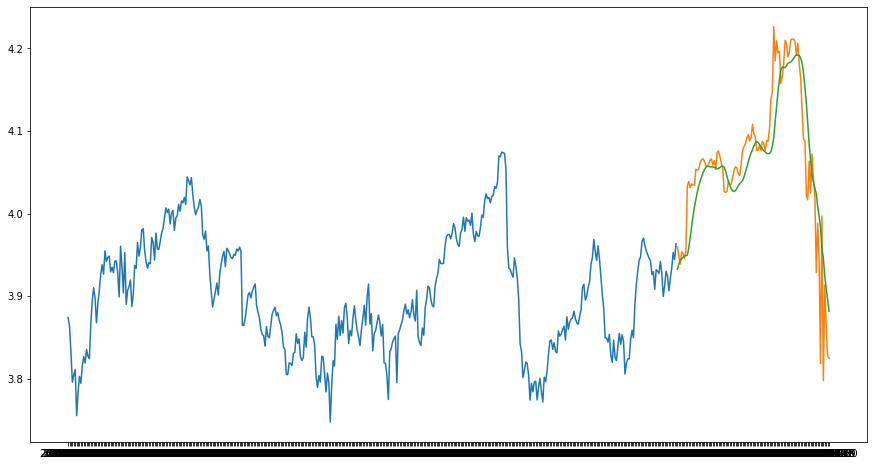

In [24]:
#for plotting
train = new_data[:train_rows]
valid = new_data[train_rows:]

valid['Predictions'] = closing_price

rcParams['figure.figsize'] = 15,8
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])

#plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_LSTM_lv2.jpg')

### 4.7.1 Save Model